In [1]:
import numpy as np
import pandas as pd
from astropy import table
import h5py
from pathlib import Path
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
import matplotlib.pyplot as plt
import fastparquet
from scipy import interpolate
import opencosmo as oc

In [2]:
# TOTAL_SIM_AREA = 1783.25 # After applying a dec > 66 cut to mask out problematic regions (issues with matching randoms to footprint)
TOTAL_SIM_AREA = 1121 # Using the new mocks with SEDs

In [55]:
import opencosmo as oc
data_path = '/global/homes/y/yoki/roman/desi_like_samples/diffsky/data/sim_data/elg_1000deg2/elg_sim_cat_galacticus_sfh.hdf5'
sim_cat = oc.open(data_path)
sim_cat = sim_cat.data.to_pandas()


In [56]:
# sim_cat

### What are the RA and DEC limits of the simulated galaxy footprint?

In [2]:
# ra_min = np.min(sim_cat['ra'])
# ra_max = np.max(sim_cat['ra'])
# dec_min = np.min(sim_cat['dec'])
# dec_max = np.max(sim_cat['dec'])

# print(f'This footprint spans RA {ra_min} to {ra_max} ')
# print(f'This footprint spans DEC {dec_min} to {dec_max}')

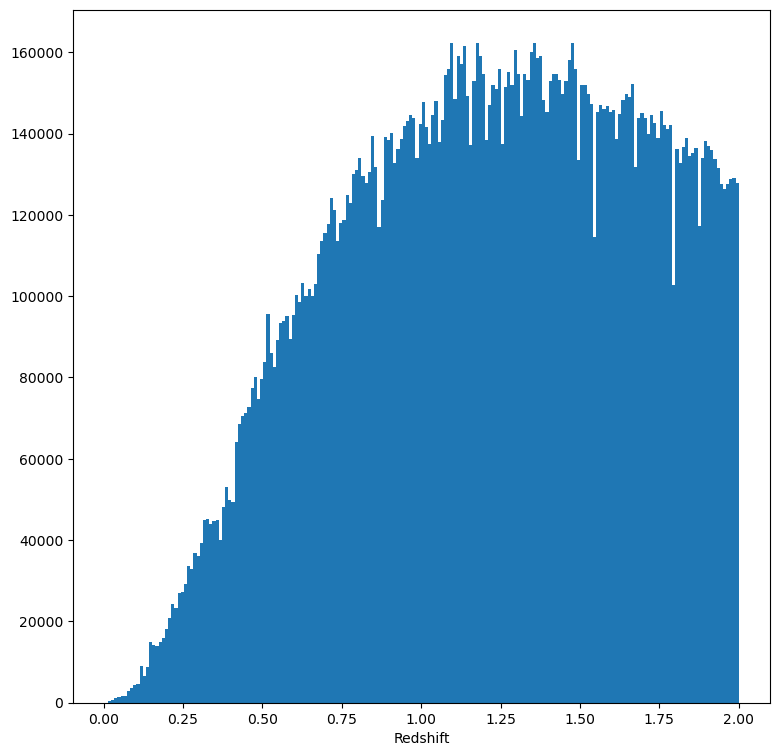

In [4]:


plt.figure(figsize = (9,9))
plt.hist(sim_cat['redshift_true'], bins=200)
plt.xlabel('Redshift')

plt.show()

In [1]:


# plt.figure(figsize = (9,9))
# plt.scatter(sim_cat['ra'], sim_cat['dec'], label='sim data', s=0.01, alpha=0.02)
# # plt.axhline(y=87, color='black')
# # plt.axhline(y=81.5, color='black')
# # plt.axvline(x=100, color='black')
# # plt.axvline(x=260, color='black')
# plt.xlabel('RA')
# plt.ylabel('DEC')
# plt.show()

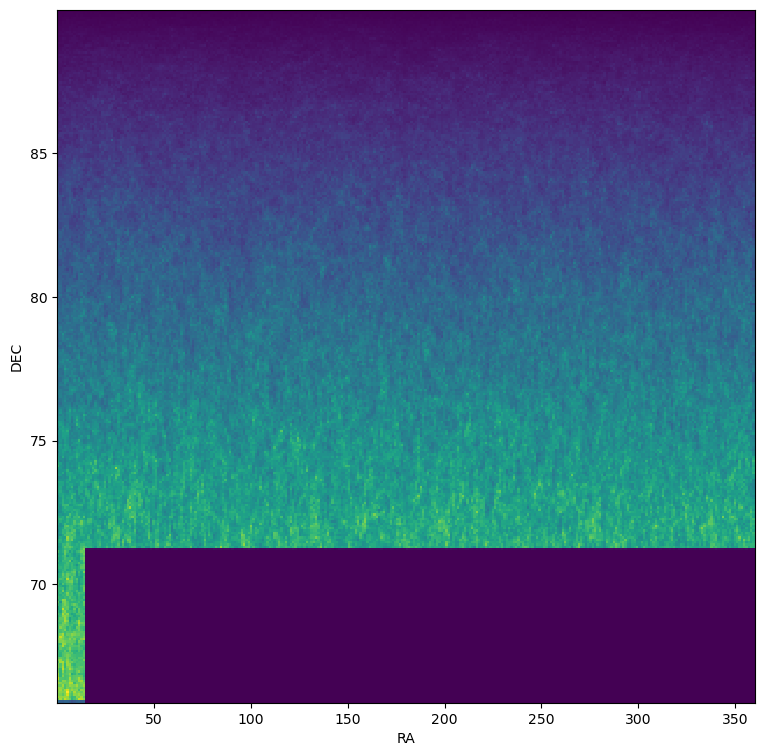

In [57]:

plt.figure(figsize = (9,9))
plt.hist2d(sim_cat['ra'], sim_cat['dec'], label='sim data', bins=300)
# plt.axhline(y=60.5, color='black')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

In [14]:
# plt.hist(sim_cat['redshift'])
# plt.xlabel('Redshift')
# plt.xlim(0, 0.005)
# plt.show()

In [15]:
# plt.hist(sim_cat['log_sfr'])
# plt.xlabel('Log10(SFR)')
# plt.show()

In [58]:

LOP_NORTH_AREA = 4400
LOP_SOUTH_DECAL_AREA = 8500
LOP_SOUTH_DES_AREA = 1100
TOTAL_DESI_AREA = 14000
DESI_ELG_ZBIN_WIDTH = 0.05
Z_GRID_POINTS = 481
ELG_TARG_DENS_AVG = (1930 + 1950 + 1900) / 3



# load in the desi ELG distributions 
path_desi_data = '/pscratch/sd/y/yoki/desi_like_data_diffsky/data/desi_sv_data/desi_elg_ts_zenodo/main-800coaddefftime1200-nz-zenodo.ecsv'
desi_data = table.Table.read(path_desi_data, format='ascii.ecsv')
desi_data.colnames

zmin = desi_data['ZMIN']
zmax = desi_data['ZMAX']
z_bin_centers = (zmin + zmax ) / 2 
zgrid = np.linspace(np.min(zmin), np.max(zmax), Z_GRID_POINTS)
SELECTION_ZBIN_WIDTH = (np.max(zmax) - np.min(zmin)) / (Z_GRID_POINTS - 1)

lop_north = desi_data['ELG_LOP_NORTH']
lop_south_decal = desi_data['ELG_LOP_SOUTH_DECALS']
lop_south_des = desi_data['ELG_LOP_SOUTH_DES']
vlo_north = desi_data['ELG_VLO_NORTH']
vlo_south_decal = desi_data['ELG_VLO_SOUTH_DECALS']
vlo_south_des = desi_data['ELG_VLO_SOUTH_DES']

lop_desi = desi_data['ELG_LOP_DESI']
vlo_desi = desi_data['ELG_VLO_DESI']
weightedavg = (lop_north * LOP_NORTH_AREA + lop_south_decal * LOP_SOUTH_DECAL_AREA  + lop_south_des * LOP_SOUTH_DES_AREA  )/(TOTAL_DESI_AREA)

In [59]:
len(zgrid)

481

In [60]:
# zgrid

In [61]:
repeat_n = int((Z_GRID_POINTS-1)/len(z_bin_centers))
new_zmin = np.linspace(np.min(zmin), np.max(zmax), Z_GRID_POINTS)[:-1]
new_zmax = np.linspace(np.min(zmin), np.max(zmax), Z_GRID_POINTS)[1:]
new_z_center = (new_zmax + new_zmin) / 2
new_weightedavg = np.repeat(weightedavg, repeat_n) / repeat_n

from scipy.interpolate import interp1d
interpf = interp1d(z_bin_centers, weightedavg, fill_value=0, bounds_error=False)
interp_weightedavg = interpf(new_z_center) / repeat_n

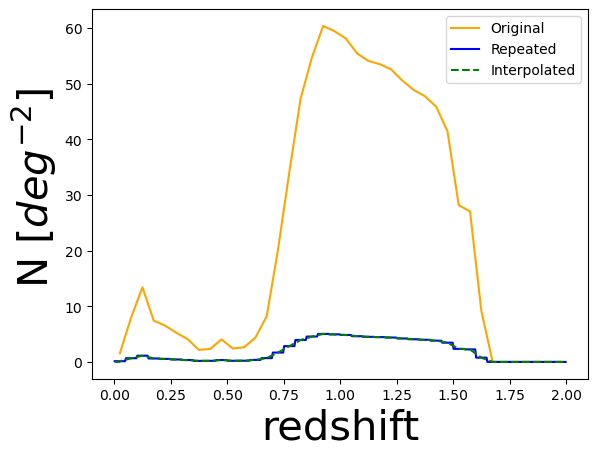

In [62]:
plt.plot(z_bin_centers, weightedavg, color='orange', label='Original')
plt.plot(new_z_center, new_weightedavg, color='blue', label='Repeated')
plt.plot(new_z_center, interp_weightedavg, ls='--', color='green', label='Interpolated')
plt.xlabel('redshift', fontsize=30)
plt.ylabel(' N [$deg^{-2}]$', fontsize=30)
plt.legend()


In [36]:
# new_weightedavg

In [63]:
print(f'The orignal weighted sum of #/deg2 for elgs is {np.sum(weightedavg)}, the interpolated version is {np.sum(interp_weightedavg)}, and the repeated version is {np.sum(new_weightedavg)}')

The orignal weighted sum of #/deg2 for elgs is 920.6421938592705, the interpolated version is 919.8712331380118, and the repeated version is 920.6421938592705


In [47]:
values, edges = np.histogram(sim_cat['redshift_true'], bins=zgrid)
values_sim = values / TOTAL_SIM_AREA
z_frac = (interp_weightedavg) / values_sim




In [48]:
# z_frac

In [64]:
z_frac = np.minimum(z_frac, np.ones(len(z_frac))*0.99)


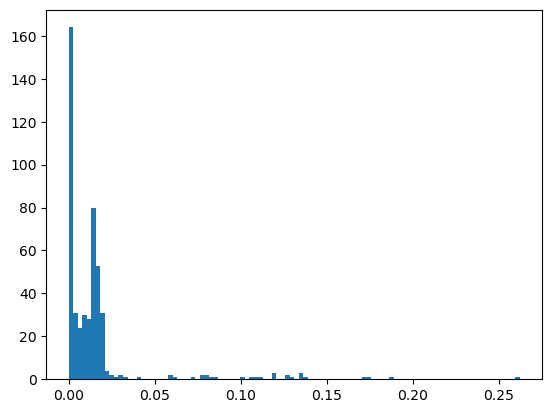

In [65]:
plt.hist(z_frac, bins=100)
plt.show()

In [32]:
len(z_frac)

480

In [66]:
sfr_thres_list = []

for i in range(len(new_z_center)):
    print(i)
    this_zmin = new_zmin[i]
    this_zmax = new_zmax[i]

    this_cat = sim_cat[np.logical_and(sim_cat['redshift_true']>this_zmin, sim_cat['redshift_true']<this_zmax)]

    if len(this_cat) == 0:
        print(f"Empty bin: zmin={this_zmin}, zmax={this_zmax}")
    
    this_sfr_thres = np.percentile(a = this_cat['log_sfr'], q = 100-z_frac[i]*100)
    sfr_thres_list.append(this_sfr_thres)

sfr_thres = np.array(sfr_thres_list)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [67]:
path_sfr_thres = f'/pscratch/sd/y/yoki/desi_like_data_diffsky/data/selection_thresholds/elg/sfr_thres_galacticus_sfh.npy'
np.save(path_sfr_thres, sfr_thres)

In [68]:
# np.diff(zgrid)

(0.0, 2.0)

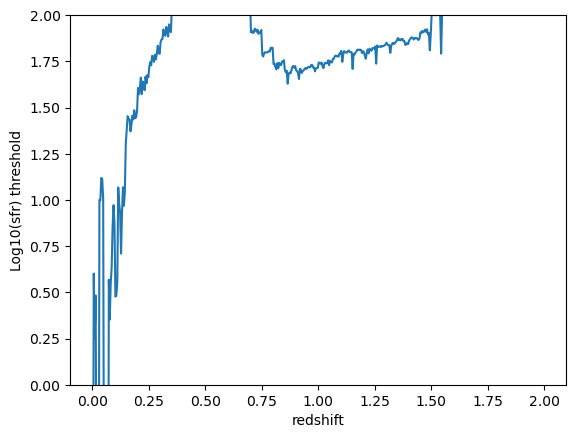

In [24]:
plt.plot(new_z_center, (sfr_thres), c='C0')
plt.xlabel('redshift')
plt.ylabel('Log10(sfr) threshold')
# plt.plot(z_bin_centers, (smooth_thres), c='C1')
# plt.plot(z_fine_grid, (sfr_fine_grid), ls='--' , c='C2')
# plt.yscale('log')
# plt.xlim(0,1.5)
plt.ylim(0,2)